<a href="https://colab.research.google.com/github/Simoni2412/Wrinkles-Detection/blob/main/Unet_CNN_for_wrinkles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mediapipe==0.10.5

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

import cv2
import numpy as np
#import mediapipe as mp
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2D, UpSampling2D, BatchNormalization, ReLU, Multiply, Input, GlobalAveragePooling2D, Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, MaxPooling2D, Dropout, Add, ZeroPadding2D
from tensorflow.keras.layers import Concatenate as Concat
from google.colab.patches import cv2_imshow
from PIL import Image
import os

In [ ]:
base_path = "/content/drive/MyDrive/Dataset /"
mask_path = base_path + "Mannual_wrinkle_annotation/"
image_path = base_path + "Original/"
# ground_truth = base_path + "Ground_Truth/"
# spare_gt = base_path + "GT/"
val_image_path = base_path + "Val_images/"
val_mask_path = base_path + "Val_mask/"

In [ ]:
# def image_processing(image_path):
#     try:
#         image = Image.open(image_path).convert('RGB')
#     except Image.DecompressionBombError:
#         print("Image is too large, trying to open with limited size...")
#         Image.MAX_IMAGE_PIXELS = None
#         image = Image.open(image_path).convert('RGB')
#     max_width = 256
#     max_height = 256
#     image.thumbnail((max_width, max_height), Image.LANCZOS)
#     image = np.array(image)  # Now a NumPy array, shape (H, W, 3)
#     return image

In [ ]:
IMG_SIZE = (256, 256)

def preprocess_image(image_path, mask_path, n_classes=1):
    # Read image
    image = cv2.imread(image_path.numpy().decode('utf-8'))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Enhancement (CLAHE + bilateral)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    #filtered = cv2.bilateralFilter(enhanced, 9, 75, 75)
    normalized = enhanced.astype(np.float32) / 255.0

    # Convert to 3 channels
    image = np.stack([normalized]*3, axis=-1)
    #image = np.stack([filtered]*3, axis=-1)
    image = cv2.resize(image, IMG_SIZE)

    # Read mask
    mask = cv2.imread(mask_path.numpy().decode('utf-8'), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, IMG_SIZE, interpolation=cv2.INTER_NEAREST)
    if n_classes == 1:
        mask = (mask > 127).astype(np.float32)
        mask = mask[..., None]
    else:
        # For multiclass, ensure mask values are 0, 1, 2, ...
        mask = mask.astype(np.uint8)
        mask = mask[..., None]
    return image, mask

def tf_preprocess_image(image_path, mask_path, n_classes=1):
    image, mask = tf.py_function(
        func=preprocess_image,
        inp=[image_path, mask_path, n_classes],
        Tout=[tf.float32, tf.float32 if n_classes==1 else tf.uint8]
    )
    image.set_shape([IMG_SIZE[0], IMG_SIZE[1], 3])
    mask.set_shape([IMG_SIZE[0], IMG_SIZE[1], 1])
    return image, mask

def get_dataset(image_dir, mask_dir, batch_size=8, augment=False):
    image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
    mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])
    dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
    dataset = dataset.map(lambda x, y: tf_preprocess_image(x, y, n_classes), num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        dataset = dataset.map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


# Simple augmentation: random flip
def augment_fn(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)
    return image, mask

In [ ]:
from typing import Concatenate
class GaussianFilterLayer(Layer):
    def __init__(self, **kwargs):
        super(GaussianFilterLayer, self).__init__(**kwargs)

    def call(self, x):
        gaussian_kernel = tf.constant([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype=tf.float32)
        gaussian_kernel = gaussian_kernel[:, :, None, None] / 16  # Normalized kernel
        gaussian_kernel = tf.repeat(gaussian_kernel, repeats=x.shape[-1], axis=-1)
        return tf.nn.conv2d(x, filters=tf.cast(gaussian_kernel, tf.float32), strides=[1,1,1,1], padding="SAME")

def spatial_attention(x):
    avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(x)
    max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(x)
    #max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    sa = layers.Conv2D(1, 7, padding='same', activation='sigmoid')(concat)
    return layers.Multiply()([x, sa])

# def channel_attention(x):
#     """ Channel Attention Module for refinement """
#     avg_pool = GlobalAveragePooling2D()(x)
#     dense1 = Dense(x.shape[-1] // 2, activation="relu")(avg_pool)
#     dense2 = Dense(x.shape[-1], activation="sigmoid")(dense1)
#     dense2 = tf.keras.layers.Reshape((1, 1, x.shape[-1]))(dense2)  # Ensure correct shape
#     return Multiply()([x, dense2])

# ---- Attention Module ----
def attention_block(x, g, inter_channels):
    theta_x = Conv2D(inter_channels, (1,1), padding="same")(x)
    phi_g = Conv2D(inter_channels, (1,1), padding="same")(g)
    add_xg = Add()([theta_x, phi_g])
    act_xg = Activation('relu')(add_xg)
    psi = Conv2D(1, (1,1), padding="same", activation="sigmoid")(act_xg)
    return Multiply()([x, psi])

def conv_block(x, filters):
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def wrinkle_segmentation_model(input_shape):
    """ Define U-Net with Spatial & Channel Attention """
    inputs = Input(shape=input_shape)
    # Encoder
    conv1 = conv_block(inputs, 32)
    pool1 = MaxPooling2D()(conv1)

    conv2 = conv_block(pool1, 64)
    pool2 = MaxPooling2D()(conv2)

    conv3 = conv_block(pool2, 128)
    pool3 = MaxPooling2D()(conv3)

    conv4 = conv_block(pool3, 256)
    pool4 = MaxPooling2D()(conv4)

    # Bottleneck
    bneck = conv_block(pool4, 512)
    bn = spatial_attention(bneck)

    # Decoder
    up4 = UpSampling2D()(bneck)
    attn4 = attention_block(conv4, up4, 256)
    merge4 = Concat()([up4, attn4])
    conv5 = conv_block(merge4, 256)

    up3 = UpSampling2D()(conv5)
    attn3 = attention_block(conv3, up3, 128)
    merge3 = Concat()([up3, attn3])
    conv6 = conv_block(merge3, 128)

    up2 = UpSampling2D()(conv6)
    attn2 = attention_block(conv2, up2, 64)
    merge2 = Concat()([up2, attn2])
    conv7 = conv_block(merge2, 64)

    up1 = UpSampling2D()(conv7)
    attn1 = attention_block(conv1, up1, 32)
    merge1 = Concat()([up1, attn1])
    conv8 = conv_block(merge1, 32)

    # Output layer

    output_layer = Conv2D(1, 1, activation="sigmoid", padding="same")(conv8)


    model = Model(inputs, output_layer)
    return model

def wrinkle_scoring(wrinkle_mask):
    """ Calculate wrinkle score using weighted contrast analysis """
    score = np.sum(wrinkle_mask) / (wrinkle_mask.shape[0] * wrinkle_mask.shape[1])
    return np.clip(score * 100, 0, 100)  # Normalize score

def predict_age(wrinkle_score):

    """ Map wrinkle score to estimated age range """
    if wrinkle_score < 20:
        return "20-30 years"
    elif wrinkle_score < 40:
        return "30-40 years"
    elif wrinkle_score < 60:
        return "40-50 years"
    else:
        return "50+ years"

In [ ]:
from tensorflow.keras import layers, models

def additive_attention_module(encoder_feat, decoder_feat, filters):
    # Upsample decoder feature to match encoder spatial size
    up_dec = layers.UpSampling2D()(decoder_feat)
    up_dec = layers.Conv2D(filters, 3, padding='same')(up_dec)
    up_dec = layers.BatchNormalization()(up_dec)
    up_dec = layers.Activation('relu')(up_dec)

    # 1x1 convs for encoder and decoder features
    theta_x = layers.Conv2D(filters, 1, padding='same')(encoder_feat)
    phi_g = layers.Conv2D(filters, 1, padding='same')(up_dec)

    # Add and activate
    add = layers.Add()([theta_x, phi_g])
    act = layers.Activation('relu')(add)
    psi = layers.Conv2D(1, 1, padding='same')(act)
    psi = layers.Activation('sigmoid')(psi)

    # Multiply attention map with encoder features
    attn_out = layers.Multiply()([encoder_feat, psi])

    # Concatenate with upsampled decoder features
    out = layers.Concatenate()([up_dec, attn_out])
    return out

def spatial_attention(x):
    avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(x)
    max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(x)
    #max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    sa = layers.Conv2D(1, 7, padding='same', activation='sigmoid')(concat)
    return layers.Multiply()([x, sa])

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_unet_paper(input_shape=(256,256,3), n_classes=1, padding=32):
    inputs = layers.Input(input_shape)
    # Zero-padding
    x = layers.ZeroPadding2D(padding=padding)(inputs)

    # Encoder
    c1 = conv_block(x, 32)
    p1 = layers.MaxPooling2D()(c1)
    c2 = conv_block(p1, 64)
    p2 = layers.MaxPooling2D()(c2)
    c3 = conv_block(p2, 128)
    p3 = layers.MaxPooling2D()(c3)
    c4 = conv_block(p3, 256)
    p4 = layers.MaxPooling2D()(c4)

    # Bottleneck + spatial attention
    bn = conv_block(p4, 512)
    bn = spatial_attention(bn)

    # Decoder with AAM
    d4 = additive_attention_module(c4, bn, 256)
    d4 = conv_block(d4, 256)
    d3 = additive_attention_module(c3, d4, 128)
    d3 = conv_block(d3, 128)
    d2 = additive_attention_module(c2, d3, 64)
    d2 = conv_block(d2, 64)
    d1 = additive_attention_module(c1, d2, 32)
    d1 = conv_block(d1, 32)

#Output
    if n_classes == 1:
        outputs = layers.Conv2D(1, 1, activation='sigmoid')(d1)
    else:
        outputs = layers.Conv2D(n_classes, 1, activation='softmax')(d1)
    return models.Model(inputs, outputs)
    # return models.Model(inputs, outputs)

# def attention_unet(input_shape=(256,256,3), n_classes=1):
#     inputs = layers.Input(input_shape)
#     # Encoder
#     c1 = conv_block(inputs, 32)
#     p1 = layers.MaxPooling2D()(c1)
#     c2 = conv_block(p1, 64)
#     p2 = layers.MaxPooling2D()(c2)
#     c3 = conv_block(p2, 128)
#     p3 = layers.MaxPooling2D()(c3)
#     c4 = conv_block(p3, 256)
#     p4 = layers.MaxPooling2D()(c4)
#     # Bottleneck
#     bn = conv_block(p4, 512)
#     # Decoder with attention
#     u4 = layers.UpSampling2D()(bn)
#     att4 = attention_gate(c4, u4, 256)
#     u4 = layers.Concatenate()([u4, att4])
#     c5 = conv_block(u4, 256)
#     u3 = layers.UpSampling2D()(c5)
#     att3 = attention_gate(c3, u3, 128)
#     u3 = layers.Concatenate()([u3, att3])
#     c6 = conv_block(u3, 128)
#     u2 = layers.UpSampling2D()(c6)
#     att2 = attention_gate(c2, u2, 64)
#     u2 = layers.Concatenate()([u2, att2])
#     c7 = conv_block(u2, 64)
#     u1 = layers.UpSampling2D()(c7)
#     att1 = attention_gate(c1, u1, 32)
#     u1 = layers.Concatenate()([u1, att1])
#     c8 = conv_block(u1, 32)
#     # Output
#     if n_classes == 1:
#         outputs = layers.Conv2D(1, 1, activation='sigmoid')(c8)
#     else:
#         outputs = layers.Conv2D(n_classes, 1, activation='softmax')(c8)
#     return models.Model(inputs, outputs)
model = attention_unet_paper(input_shape=(256,256,3), n_classes=2, padding=32)
model.summary()

Model: "functional_5"

 Total params: 8,819,849 (33.65 MB)

 Trainable params: 8,813,001 (33.62 MB)

 Non-trainable params: 6,848 (26.75 KB)

In [ ]:
import tensorflow as tf

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dsc = dice_loss(y_true, y_pred)
    return bce + dsc

In [ ]:

# ... (rest of your code) ...

# Define early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)  # Adjust patience as needed

n_classes = 1
train_dataset = get_dataset(image_path, mask_path, batch_size=5, augment=False)
val_dataset = get_dataset(val_image_path, val_mask_path, batch_size=5, augment=False)

#model = attention_unet_paper(input_shape=(256,256,3), padding=0)
model = wrinkle_segmentation_model(input_shape=(256,256,3))
model.compile(optimizer='adam', loss=combined_loss, metrics=['accuracy'])

# Train
model.fit(train_dataset,validation_data=val_dataset, epochs=50, callbacks=[early_stop])


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 432ms/step - accuracy: 0.5020 - loss: 1.7707 - val_accuracy: 0.9033 - val_loss: 1.5533
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 412ms/step - accuracy: 0.9844 - loss: 1.3122 - val_accuracy: 0.9945 - val_loss: 1.2777
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 345ms/step - accuracy: 0.9897 - loss: 1.2245 - val_accuracy: 0.2132 - val_loss: 3.4985
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 342ms/step - accuracy: 0.9903 - loss: 1.1876 - val_accuracy: 0.9945 - val_loss: 1.3845
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 347ms/step - accuracy: 0.9906 - loss: 1.1558 - val_accuracy: 0.9945 - val_loss: 1.3010
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 407ms/step - accuracy: 0.9907 - loss: 1.1349 - val_accuracy: 0.9945 - val_loss: 1.2365
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 426ms/step - accuracy: 0.9908 - loss: 1.1172 - val_accuracy: 0.9945 - val_loss: 1.2152
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 342ms/step - accuracy: 0.9908 - loss: 1.1013 - val_accurac

In [ ]:
model.save('model_yesspatial_noaugment_batch5.h5')

In [ ]:
for images, masks in train_dataset.take(1):
    preds = model.predict(images)
    break  # Only take the first batch


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
print("Prediction min:", preds.min(), "max:", preds.max(), "mean:", preds.mean())

Prediction min: 2.1104902e-06 max: 0.9999832 mean: 0.0055360626


In [ ]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dsc = dice_loss(y_true, y_pred)
    return bce + dsc

In [ ]:
dice_loss = dice_loss(masks, preds)
print("Dice loss:", dice_loss.numpy())

Dice loss: 0.6051528


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_sample(image, mask, pred):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(pred.squeeze(), cmap='gray')
    plt.title('Prediction')
    plt.axis('off')
    plt.show()

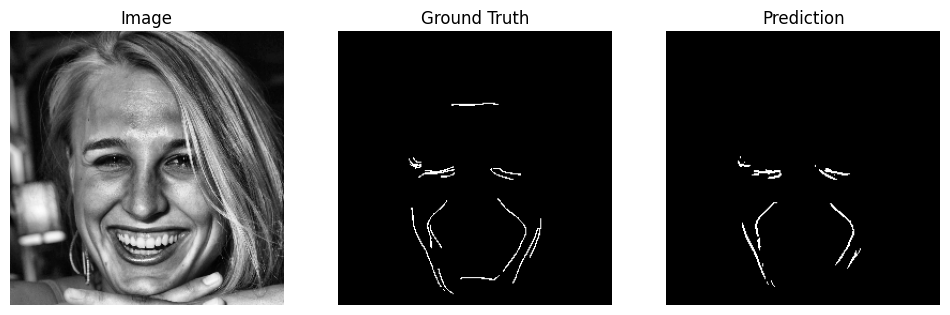

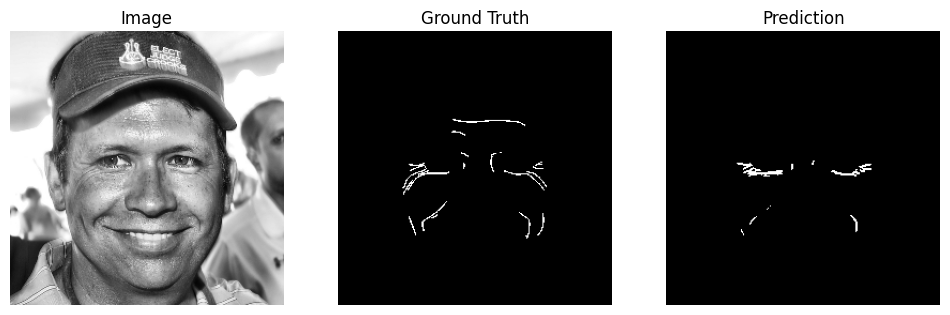

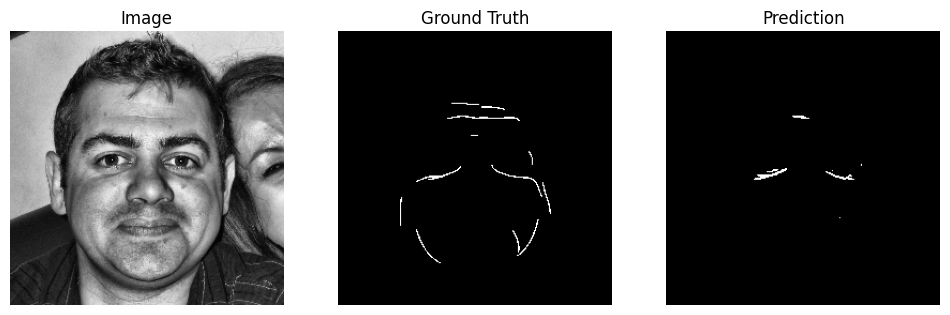

In [ ]:
for i in range(min(3, images.shape[0])):  # Show up to 3 samples
    display_sample(
        images[i].numpy(),
        masks[i].numpy(),
        (preds[i] > 0.5).astype(np.float32)  # Threshold sigmoid output
    )

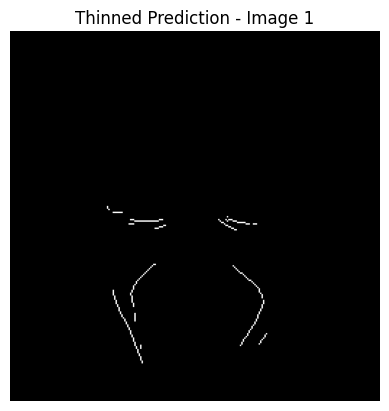

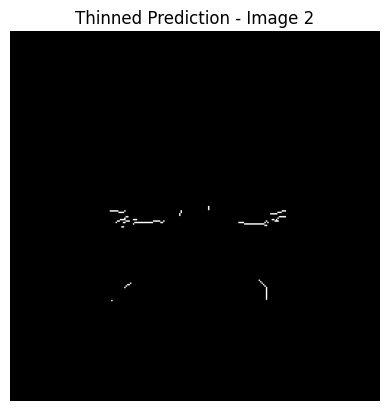

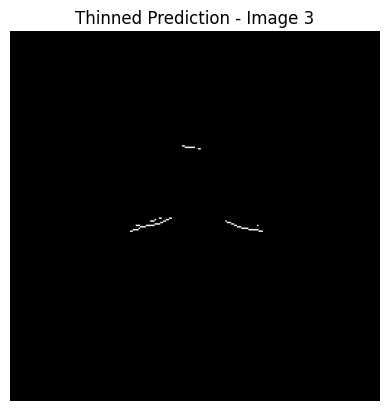

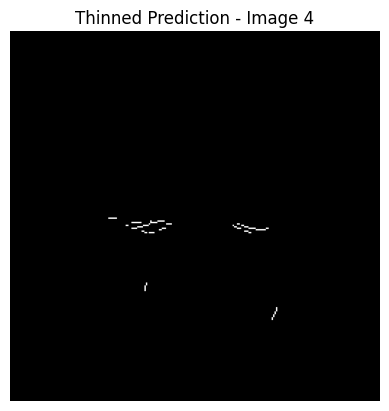

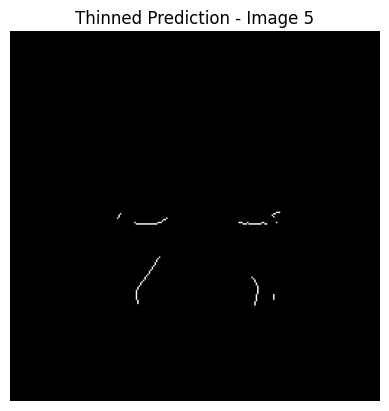

In [ ]:
from skimage.morphology import skeletonize
def thined_prediction(preds):
    # Iterate through each image in the batch
# Iterate through each image in the batch
  for i in range(preds.shape[0]):
    thin_mask = skeletonize(preds[i].squeeze() > 0.9)  # Process each image individually
    plt.imshow(thin_mask, cmap='gray')
    plt.title(f'Thinned Prediction - Image {i + 1}')
    plt.axis('off')
    plt.show()
thinned = thined_prediction(preds)
thinned

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


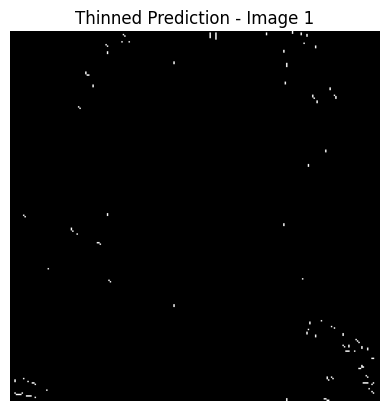

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Dataset /Original/00420.png')
#img = image_processing(img_path)
#img = preprocess_image(img)
img = cv2.resize(img, (256, 256))
#img = img.astype(np.float32) / 255.0
#img = np.expand_dims(img, axis=0)
input_batch = np.expand_dims(img, axis=0)
pred = model.predict(input_batch)
thinned = thined_prediction(pred)
#plt.imshow(thinned, cmap='gray')
plt.show()